## Import packages

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## Import and clean the dataset

In [ ]:
# Load the dataset
file_path = "/content/deathrate.csv"
df = pd.read_csv(file_path)

# Preprocess the data (drop missing values)
df_clean = df.dropna(subset=['deathrate', 'sulphur'])

print(df_clean.head())

   Unnamed: 0  deathrate  rain  tempjan  tempjuly  over65  homesize  studies  \
0           1    921.870    36       27        71     8.1      3.34     11.4   
1           2    997.875    35       23        72    11.1      3.14     11.0   
2           3    962.354    44       29        74    10.4      3.21      9.8   
3           4    982.291    47       45        79     6.5      3.41     11.1   
4           5   1071.289    43       35        77     7.6      3.44      9.6   

   kitchen  density  ...  poor  hydrocarbon  nitrogen  sulphur  humidity  \
0     81.5     3243  ...  11.7           21        15       59        59   
1     78.8     4281  ...  14.4            8        10       39        57   
2     81.6     4260  ...  12.4            6         6       33        54   
3     77.5     3125  ...  20.6           18         8       24        56   
4     84.6     6441  ...  14.3           43        38      206        55   

     noise1    noise2    noise3    noise4    noise5  
0 -0.996

In [ ]:
print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   60 non-null     int64  
 1   deathrate    60 non-null     float64
 2   rain         60 non-null     int64  
 3   tempjan      60 non-null     int64  
 4   tempjuly     60 non-null     int64  
 5   over65       60 non-null     float64
 6   homesize     60 non-null     float64
 7   studies      60 non-null     float64
 8   kitchen      60 non-null     float64
 9   density      60 non-null     int64  
 10  nonwhite     60 non-null     float64
 11  employed     60 non-null     float64
 12  poor         60 non-null     float64
 13  hydrocarbon  60 non-null     int64  
 14  nitrogen     60 non-null     int64  
 15  sulphur      60 non-null     int64  
 16  humidity     60 non-null     int64  
 17  noise1       60 non-null     float64
 18  noise2       60 non-null     float64
 19  noise3    

## Some data visualization

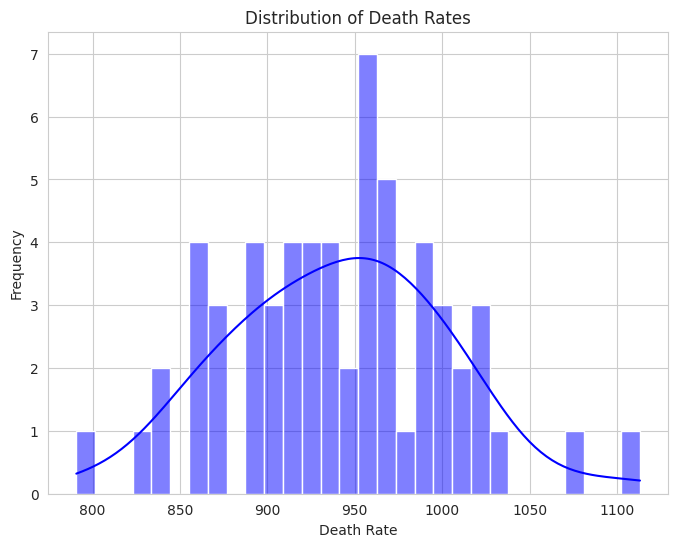

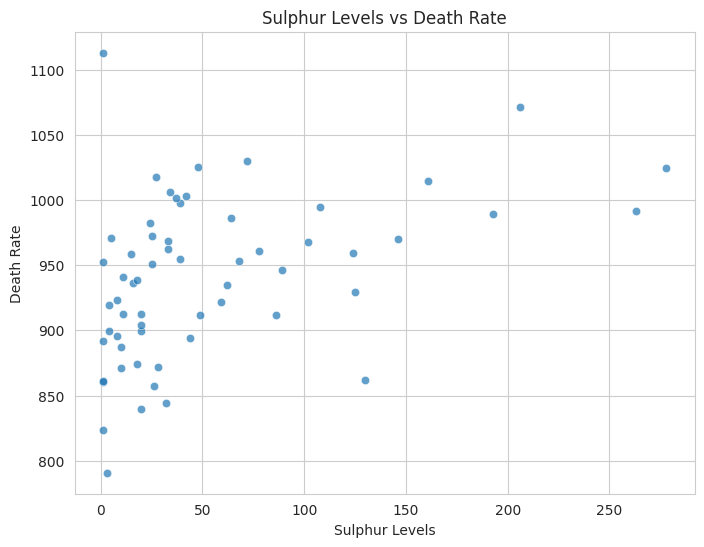

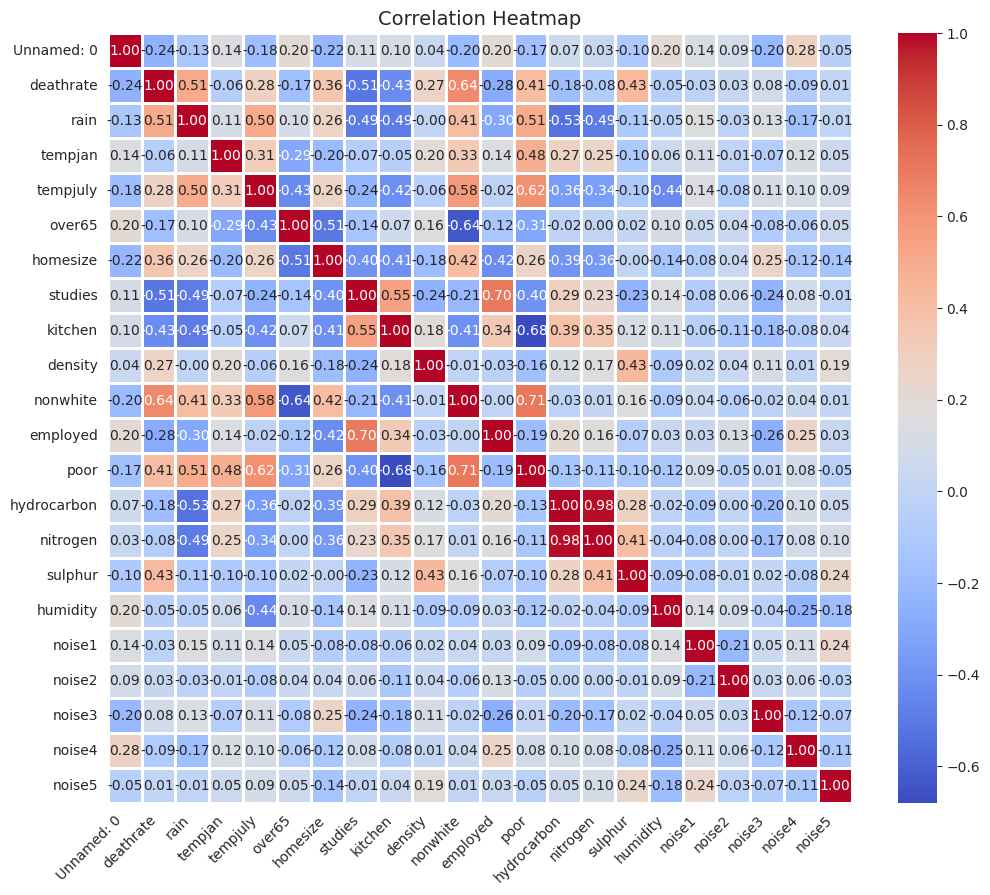

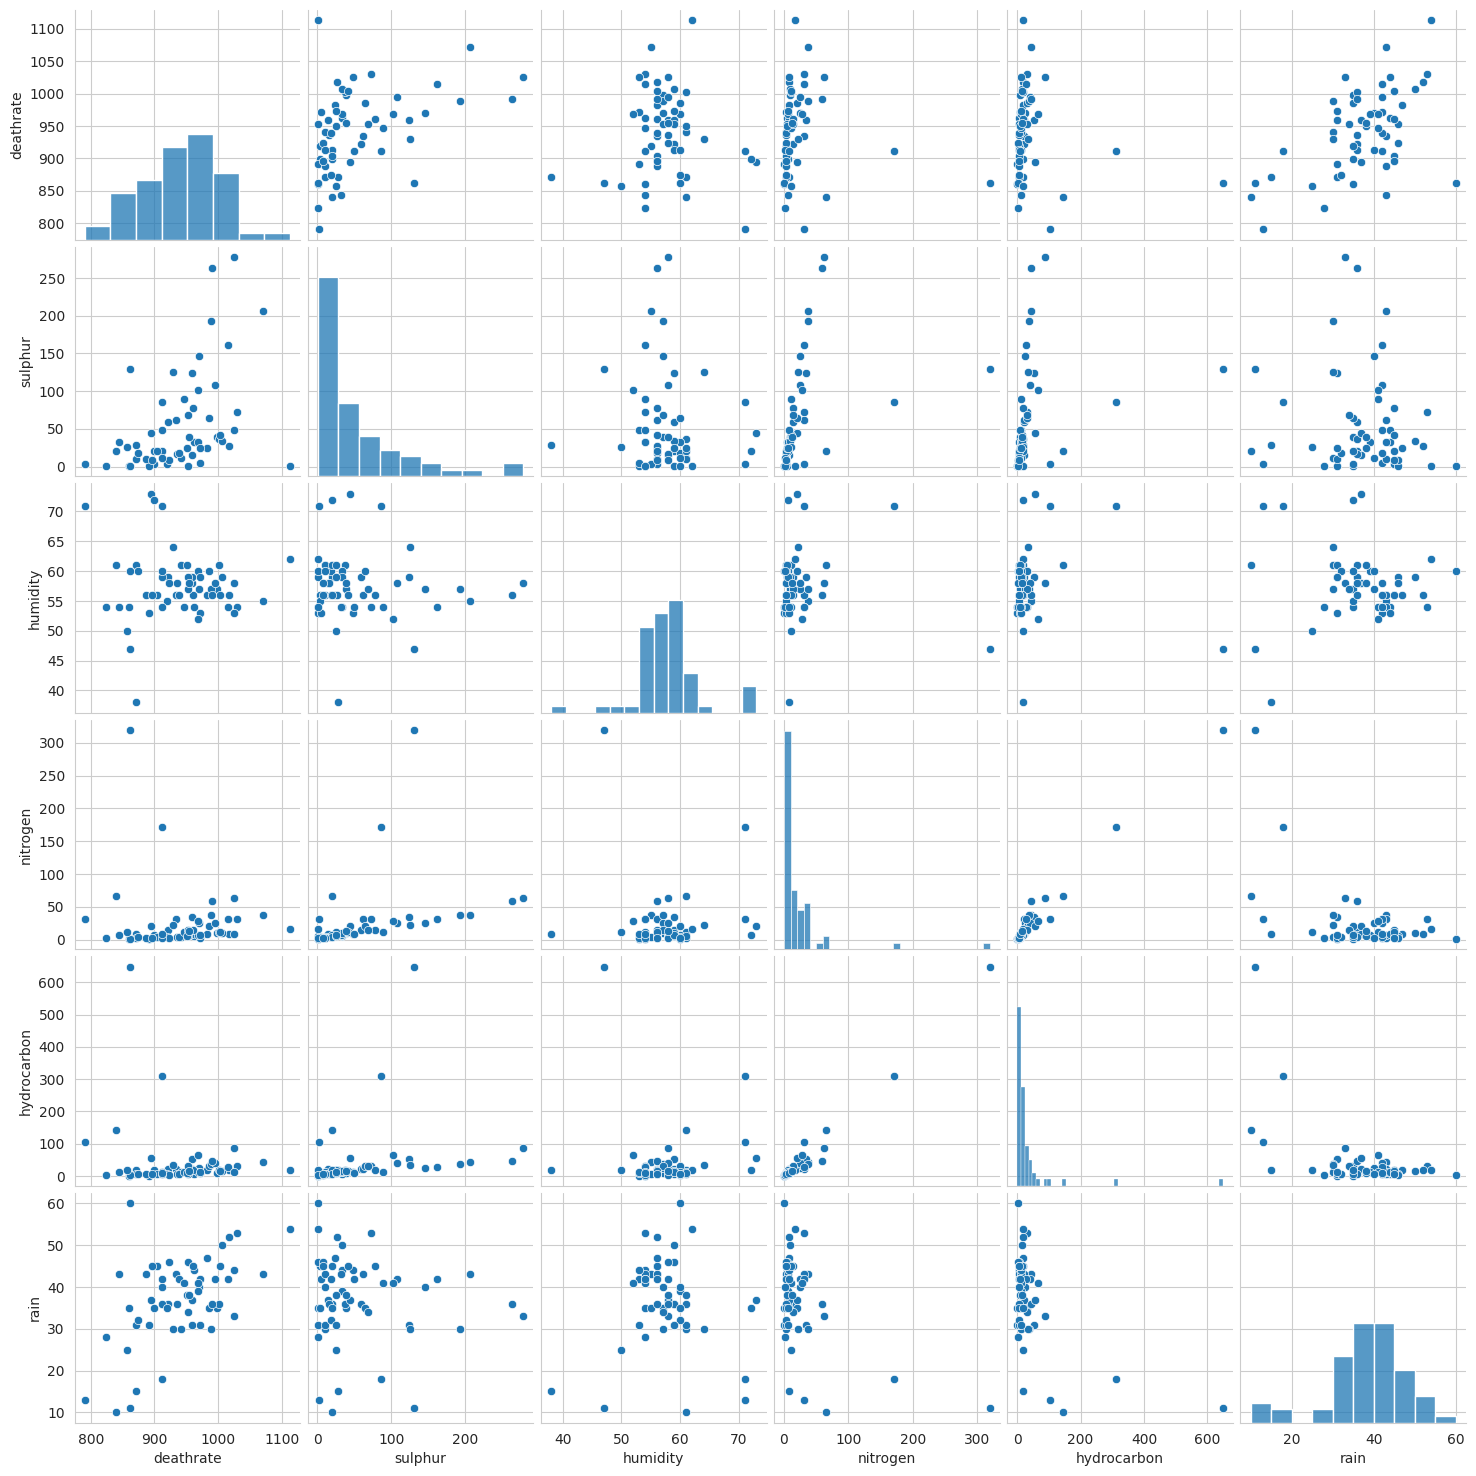

In [ ]:
# Set plot style
sns.set_style("whitegrid")

# Histogram of Death Rates
plt.figure(figsize=(8,6))
sns.histplot(df_clean['deathrate'], bins=30, kde=True, color='blue')
plt.xlabel('Death Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Death Rates')
plt.show()

# Scatter Plot: Sulphur vs Death Rate
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_clean['sulphur'], y=df_clean['deathrate'], alpha=0.7)
plt.xlabel('Sulphur Levels')
plt.ylabel('Death Rate')
plt.title('Sulphur Levels vs Death Rate')
plt.show()

# Correlation Heatmap with Improved Readability
plt.figure(figsize=(12,10))
corr_matrix = df_clean.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, annot_kws={"size": 10})
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title('Correlation Heatmap', fontsize=14)
plt.show()

# Pairplot of Selected Variables
selected_vars = ['deathrate', 'sulphur', 'humidity', 'nitrogen', 'hydrocarbon','rain']
sns.pairplot(df_clean[selected_vars])
plt.show()



## Test the algorithm of the paper

Hypotheses:

  (Null Hypothesis): Sulphur levels do not significantly impact death rates.

  (Alternative Hypothesis): Sulphur levels significantly impact death rates.



Define competing models:

 $M_{0}$: Death rate depends only on an intercept.

 $M_{1}$: Death rate depends on sulphur levels.

In [ ]:
# Set seed for reproducibility
np.random.seed(1)

Running Trials: 100%|██████████| 100/100 [00:39<00:00,  2.52iteration/s]


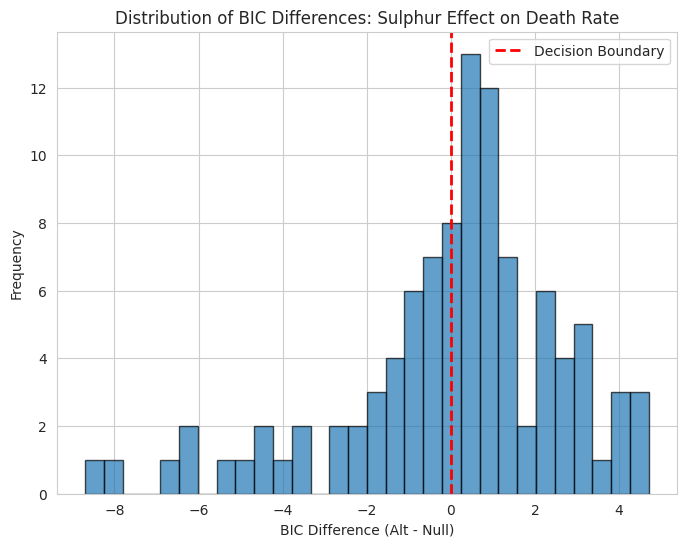

Posterior Probability that Rain Affects Death Rate: 0.58


In [ ]:
# Define independent and dependent variables
X = df_clean[['sulphur']]
y = df_clean['deathrate']
X = sm.add_constant(X)

# Specify number of trials and final sample size
B = 100
N = len(y) + 100

# Store results
bic_diffs = []
final_models = []

# Add a progress bar for the first loop
for b in tqdm(range(B), desc="Running Trials", unit="iteration"):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=b)

    # Fit the null model (only intercept)
    null_model = sm.OLS(y_train, sm.add_constant(np.ones(len(y_train)))).fit()

    # Fit the alternative model (sulphur as predictor)
    alt_model = sm.OLS(y_train, X_train).fit()

    # Compute BIC for both models
    n = len(y_train)
    d_null = 1  # Intercept only
    d_alt = X_train.shape[1]  # Intercept + sulphur predictor

    bic_null = d_null * np.log(n) - 2 * null_model.llf
    bic_alt = d_alt * np.log(n) - 2 * alt_model.llf

    # Initialize training data for predictive resampling
    X_resampled = X_train.copy()
    y_resampled = y_train.copy()

    for i in range(n + 1, N):
        # Compute current best model based on BIC
        best_model = alt_model if bic_alt > bic_null else null_model

        # Sample new observation from the best model
        new_x = np.random.choice(X_train['sulphur'])  # Sample new sulphur level
        new_sample = pd.DataFrame([[1, new_x]], columns=['const', 'sulphur'])

        # Ensure model params are used correctly for prediction
        if best_model == null_model:
            new_y = best_model.predict(pd.DataFrame([[1]], columns=['const'])).squeeze() + np.random.choice(best_model.resid)
        else:
            new_y = best_model.predict(new_sample).squeeze() + np.random.choice(best_model.resid)

        # Append new sample to dataset
        X_resampled = pd.concat([X_resampled, new_sample], ignore_index=True)
        y_resampled = pd.concat([y_resampled, pd.Series([new_y])], ignore_index=True)

        # Recompute models with extended dataset
        null_model = sm.OLS(y_resampled, sm.add_constant(np.ones(len(y_resampled)))).fit()
        alt_model = sm.OLS(y_resampled, X_resampled).fit()

        # Recalculate BIC
        bic_null = d_null * np.log(len(y_resampled)) - 2 * null_model.llf
        bic_alt = d_alt * np.log(len(y_resampled)) - 2 * alt_model.llf

    # Store final selected model
    final_models.append(alt_model if bic_alt > bic_null else null_model)

    # Store final BIC difference
    bic_diffs.append(bic_alt - bic_null)

# Compute posterior probability
posterior_prob = np.mean(np.array(bic_diffs) > 0)

# Plot histogram of BIC differences
plt.figure(figsize=(8,6))
plt.hist(bic_diffs, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='dashed', linewidth=2, label='Decision Boundary')
plt.xlabel('BIC Difference (Alt - Null)')
plt.ylabel('Frequency')
plt.title('Distribution of BIC Differences: Sulphur Effect on Death Rate')
plt.legend()
plt.show()

# Output results
print("Posterior Probability that Rain Affects Death Rate:", posterior_prob)
